#Vehicle Number Plate Detection
This project uses opencv and yolo to detect and recognise the vehice number plates of Indian vehicles.
First of all, yolov3 is trained for given dataset(code in seperate file) and then the final weights obtained are used in this file for the detection of number plates.
After the number plates are detected and bounding boxex created, the image is cropped and passes as an argument to a website for performing OCR, which returns the vehicle recognition number.
After that, vehicle information related to that vehicle registration number is obtained from rto website by performing webscraping.

In [1]:
!pip install pillow
!pip install pytesseract
!sudo apt install tesseract-ocr

  Created wheel for pytesseract: filename=pytesseract-0.3.3-py2.py3-none-any.whl size=13396 sha256=83378040bc4ae7399beb8f9089d6b44afa4ee740adc81c728a872174f24d76c2
  Stored in directory: /root/.cache/pip/wheels/82/1a/d0/a884540a5602305f5bb7ff44f05550be20453edce8fae69241
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http:/

In [0]:
#copy required files from drive
!mkdir darknet
!cp /content/drive/"My Drive"/"Number Plate Detection"/obj.cfg /content/darknet
!cp /content/drive/"My Drive"/"Number Plate Detection"/obj.names /content/darknet
!cp /content/drive/"My Drive"/"Number Plate Detection"/obj.data /content/darknet

In [0]:
#copy trained weights from drive
!cp /content/drive/"My Drive"/"Number Plate Detection"/yolo-obj_final_vehicle.weights /content/darknet

In [0]:
import cv2
import numpy as np
import pytesseract
import pandas as pd
from google.colab.patches import cv2_imshow
def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers

In [0]:
def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


In [0]:
import numpy as np
import requests
import io
import json

url_api = "https://api.ocr.space/parse/image"
api_key = 'a0bb6cecb388957'


Function to return the vehicle registration number from the cropped image

In [0]:
def number_plate_recognition(img):
  cv2.imwrite('test.jpg', img)

  _, compressedimage = cv2.imencode(".jpg", img, [1, 90])
  file_bytes = io.BytesIO(compressedimage)

  result = requests.post(url_api,files={"test.jpg" : file_bytes},data={"apikey":api_key})
  result = result.content.decode()
  result = json.loads(result)
  #print(result)

  parsed_results = result.get("ParsedResults")[0]
  text_detected = parsed_results.get("ParsedText")
  print(text_detected)
  !rm 'test.jpg'
  return text_detected

Creating bounding boxess and then performing number plate recognition

151.jpg
(450, 429, 3)
<class 'numpy.ndarray'>
PB08 CX 2955



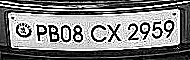

157.jpg
(224, 400, 3)
<class 'numpy.ndarray'>
HR26DA6471



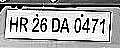

160.jpg
(267, 330, 3)
<class 'numpy.ndarray'>



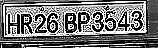

In [10]:
from PIL import Image
#image_path = '/content/darknet/data/obj/2.jpg'
image_paths = ['151.jpg', '157.jpg', '160.jpg']
weights_path = '/content/darknet/yolo-obj_final_vehicle.weights'
config_path = '/content/darknet/obj.cfg'
classes_path = '/content/darknet/obj.names'
data = []
#cause i have 32 images hence range(1,33)
for image_path in image_paths:
  vehicle_data = {}
  #image_path = '/content/darknet/data/obj/%s.jpg'%j
  print(image_path)
  image = cv2.imread(image_path)
  Width = image.shape[1]
  Height = image.shape[0]
  print(image.shape)
  scale = 0.00392

  classes = None

  with open(classes_path, 'r') as f:
      classes = [line.strip() for line in f.readlines()]

  COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

  net = cv2.dnn.readNet(weights_path, config_path)

  blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

  net.setInput(blob)

  outs = net.forward(get_output_layers(net))

  class_ids = []
  confidences = []
  boxes = []
  conf_threshold = 0.5
  nms_threshold = 0.4


  for out in outs:
      for detection in out:
          scores = detection[5:]
          class_id = np.argmax(scores)
          confidence = scores[class_id]
          if confidence > 0.5:
              center_x = int(detection[0] * Width)
              center_y = int(detection[1] * Height)
              w = int(detection[2] * Width)
              h = int(detection[3] * Height)
              x = center_x - w / 2
              y = center_y - h / 2
              class_ids.append(class_id)
              confidences.append(float(confidence))
              boxes.append([x, y, w, h])

  im_pil = Image.fromarray(image)

  indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

  for i in indices:
      i = i[0]
      box = boxes[i]
      x = box[0]
      y = box[1]
      w = box[2]
      h = box[3]
      #draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))
      cropped_img = im_pil.crop((x,y,x+w,y+h))
      im_np = np.asarray(cropped_img)
      sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
      img = cv2.filter2D(im_np, -1, sharpen_kernel)
      scale_percent =300 # percent of original size
      width = int(img.shape[1] * scale_percent / 100) 
      height = int(img.shape[0] * scale_percent / 100)
      dim = (width, height)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      kernel = np.ones((1, 1), np.uint8)
      img = cv2.dilate(img, kernel, iterations=1)
      img = cv2.erode(img, kernel, iterations=1)
      print(type(img))
      r = number_plate_recognition(img)
      vehicle_data['num'] = r
      cv2_imshow(img) #uncomment cv2_imshow if you want to see cropped image
      cv2.waitKey()
  data.append(vehicle_data['num'])


In [11]:
print(data)

['PB08 CX 2955\r\n', 'HR26DA6471\r\n', '']


##Web-scraping part
Mechanize and BeautifulSoup python libraries are used to extract the data related to a vehicle, from a given vehicle registration number.

In [12]:
!pip install mechanize
!pip install bs4

     |████████████████████████████████| 112kB 4.7MB/s 


In [0]:
from mechanize import Browser
from bs4 import BeautifulSoup

url = 'http://www.rtovehicleinformation.com/'

def get_vehicle_data(vehicle_num):    
    br = Browser()
    br.set_handle_robots(False)

    print("Connecting..")
    br.open(url)
    br.select_form('rto_adres_form1')
    br.form['vehicle_shrt_name'] = vehicle_num

    response = br.submit()

    #get all attributes related to an object.
    #print(dir(response))
    print("Connected to " + response.geturl())

    print("Extracting Data...\n")
    soup = BeautifulSoup(response.get_data(), 'html.parser')
    #print(soup.prettify())

    table = soup.find('table', id='divIncidents')
    rows = table.find_all('tr')
    ans = {}
    for i in range(5):
        data = rows[i].find_all('td')
        print(data[0].text+":  "+data[1].text)
        ans[data[0].text] = data[1].text
    return ans

Store the extracted data in a dictionary, which can be further stored in a csv file.

In [0]:
final_data = []
for vehicle in data:
  vehicle_info = get_vehicle_data(vehicle)
  final_data.append(vehicle_info)

Connecting..
Connected to http://www.rtovehicleinformation.com/rto-vehicle-information-details
Extracting Data...

Owner Name:  ARJUN SACHDEVA
Vehicle Name:  TATA MOTORS LTD / LPT 1613
Registration No.:  PB08CX2955
Registration Date:  01-Apr-2010
Registration Authority:  JALANDHAR RTA, PUNJAB
Connecting..
Connected to http://www.rtovehicleinformation.com/rto-vehicle-information-details
Extracting Data...

Owner Name:  PRAVEEN BHIMRAO MALI
Vehicle Name:  SKODA AUTO INDIA PVT LTD / SKODA RAPID
Registration No.:  HR26DA6471
Registration Date:  22-Nov-2016
Registration Authority:  GURUGRAM NORTH, HARYANA
Connecting..
Connected to http://www.rtovehicleinformation.com/rto-vehicle-information-details
Extracting Data...

